<a href="https://colab.research.google.com/github/sahasubhajit/Speech-Spoofing-/blob/main/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install jiwer
!pip install umap-learn
!pip install eer
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=2ff7b971e1d53d9ef4defa4b68ef62aac23fb34e35ad47e9878e6d62ab9a5e2b
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from umap import UMAP
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,  PredefinedSplit
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from eer import eer, eer_tnt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
sns.set(style='white', context='poster')

In [ ]:
def load_train_data(X_train, y_train):
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return X_train, y_train

def load_validation_data(X_validation, y_validation):
  X_validation = np.array(X_validation)
  y_validation = np.array(y_validation)
  return X_validation, y_validation

def load_test_data(X_test, y_test):
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  return X_test, y_test


class MLModel:
    def __init__(self, model_type, use_supervised_umap=False, mapper=False):
        self.model_type = model_type
        self.use_supervised_umap = use_supervised_umap
        self.mapper = mapper

        if self.use_supervised_umap:
            self.umap = UMAP(n_neighbors=20, n_components=2)
            self.scaler = StandardScaler()
        if model_type == 'SVM':
            self.model = SVC(probability=True)
            self.param_grid = {'C': [0.1, 1, 5], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
        elif model_type == 'RandomForest':
            self.model = RandomForestClassifier()
            self.param_grid = {'n_estimators': [50, 75, 100], 'weights' : ['uniform', 'distance']}
        elif model_type == 'KNN':
            self.model = KNeighborsClassifier()
            self.param_grid = {'n_neighbors': [3, 5, 7]}
        elif model_type == 'LogisticRegression':
            self.model = LogisticRegression()
            self.param_grid = {'C': [0.1, 1, 5]}
        elif model_type == 'NaiveBayes':
            self.model = GaussianNB()
            self.param_grid = {}
        elif model_type == 'XGBoost':
            self.model = xgb.XGBClassifier()
            self.param_grid = {'max_depth': [5, 10, 15], 'learning_rate': [0.1, 0.01]}
        elif model_type == 'DecisionTree':
            self.model = DecisionTreeClassifier()
            self.param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}

        elif model_type == 'MLP':
            self.model = MLPClassifier()
            self.param_grid = {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'batch_size': [32, 64],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'alpha': [0.0001, 0.001, 0.01]
            }

        else:
            print("Unknown model name!")


    def reduce_dimension(self, X_train, y_train, X_val, y_val, algo_name = 'UMAP', supervised = True):
      if algo_name == 'UMAP':
          umap = UMAP(n_neighbors=10, n_components=2)

          if supervised:
              # Train supervised UMAP on labeled data
              mapper = umap.fit(X_train, y_train)
              embedding = mapper.transform(X_val)
          else:
              # Use unsupervised UMAP on training data
              embedding = umap.fit_transform(X_val)

          # Visualize the projection on the validation data
          fig, ax = plt.subplots(figsize=(14, 10))
          # For simplicity, assuming that y_val has the same number of classes as y_train
          # You may need to adapt this if it's not the case
          classes = [1,0]
          colors = ['red', 'green']  # Adjust colors for more classes

          for i, class_label in enumerate(classes):
              class_indices = np.where(y_val == class_label)
              plt.scatter(embedding[class_indices, 0], embedding[class_indices, 1], s=10, c=colors[i], label=f'Class {class_label}')

          plt.legend()
          plt.title('Dimension reduction via UMAP with Validation Data')
          plt.show()

          return embedding



    def preprocess_input(self, X):
        if self.use_supervised_umap:
            pass
        return X

    def train(self, X_train, y_train, X_val, y_val):
        print("{} is training ...".format(self.model_type))
        # Create the test fold for PredefinedSplit
        train_indices = np.full(len(X_train), -1)  # -1 for training set
        val_indices = np.full(len(X_val), 0)  # 0 for validation set
        test_fold = np.concatenate((train_indices, val_indices))

        # Set up GridSearchCV to find the best number of trees using F1 score
        ps = PredefinedSplit(test_fold=test_fold)
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

        # Get the best model with the optimal number of trees
        best_model = grid_search.best_estimator_

        # Make predictions on the validation set with the best model
        y_pred = best_model.predict(X_val)


        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_val, y_pred)
        precision_val = precision_score(y_val, y_pred)
        recall_val = recall_score(y_val, y_pred)
        f1_val = f1_score(y_val, y_pred)
        print("Validation Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} (Grid search has made on f1 score only)".format(
            accuracy_val, precision_val, recall_val, f1_val))


        y_pred = best_model.predict(X_train)
        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_train, y_pred)
        precision_val = precision_score(y_train, y_pred)
        recall_val = recall_score(y_train, y_pred)
        f1_val = f1_score(y_train, y_pred)
        print("Training Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_val, precision_val, recall_val, f1_val))


        # Get the best parameters found by grid search
        print("Best parameters:", grid_search.best_params_)
        self.trained_model = best_model









    def compute_eer(self, y_true, y_scores):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        return eer, eer_threshold, fpr, fnr











    def test(self, X_test, y_test):

        print("Testing {} ...".format(self.model_type))

        if self.trained_model is None:
            print("Fit the model first.")
            return





        if self.model_type == 'MLP':
            # Additional preprocessing for MLP (scaling)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Update the model with the best parameters from grid search
            self.model.set_params(**self.trained_model.best_params_)

            # Train the model with the best hyperparameters
            self.model.fit(X_train_scaled, y_train)

            # Use the trained model to make predictions on the test set
            y_pred_test = self.model.predict(X_test_scaled)

        else:
            # Use the trained model to make predictions on the test set
            y_pred_test = self.trained_model.predict(X_test)

        # Calculate metrics on the test set
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)

        print("Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_test, precision_test, recall_test, f1_test))

        # Calculate EER for test set
        y_scores_test = self.trained_model.predict_proba(X_test)[:, 1]
        eer_test, eer_threshold_test, fpr_test, fnr_test = self.compute_eer(y_test, y_scores_test)
        print("eer rate {} and threshold value {}".format(eer_test, eer_threshold_test))




        # Create an interactive ROC-AUC plot with Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr_test, y=1-fnr_test, mode='lines', name='ROC curve'))
        fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, name='Random classifier')

        fig.update_layout(
            title='Receiver Operating Characteristic (ROC) Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
        )

        fig.show()





        return fpr_test, fnr_test, eer_threshold_test




class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model_names, meta_model_name = 'NaiveBayes'):
        self.base_models = {}
        self.meta_model = GaussianNB() # Using Naive Bayes as the default meta-classifier
        if meta_model_name == 'DecisionTree':
          self.meta_model = DecisionTreeClassifier()
        else:
          print("Unvalid meta model name given! default meta model has selected")
        self.base_model_names = base_model_names

        # Train base models
        for model_name in self.base_model_names:
            if model_name == 'SVM':
                model = MLModel('SVM')
            elif model_name == 'RandomForest':
                model = MLModel('RandomForest')
            elif model_name == 'KNN':
                model = MLModel('KNN')
            elif model_name == 'LogisticRegression':
                model = MLModel('LogisticRegression')
            elif model_name == 'NaiveBayes':
                model = MLModel('NaiveBayes')
            elif model_name == 'XGBoost':
                model = MLModel('XGBoost')
            elif model_name == 'DecisionTree':
                model = MLModel('DecisionTree')
            else:
                print("Unknown model name!")

            self.base_models[model_name] = model

    def train(self, X_train, y_train, X_val, y_val):
        # Train base models
        for model_name, model in self.base_models.items():
            print("{} is training".format(model_name))
            model.train(X_train, y_train, X_val, y_val)

        # Collect predictions from base models for class 1
        meta_features = []
        for model_name, model in self.base_models.items():
            y_pred_train = model.trained_model.predict_proba(X_train)[:, 1]
            meta_features.append(y_pred_train)

        # Transpose the predictions to have the shape (n_samples, n_models)
        meta_features = np.array(meta_features).T

        # Train the meta-classifier using the meta-features
        self.meta_model.fit(meta_features, y_train)

    def test(self, X_test, y_test):
        # Collect predictions from base models for class 1
        meta_features = []
        for model_name, model in self.base_models.items():
            y_pred_test = model.trained_model.predict_proba(X_test)[:, 1]
            meta_features.append(y_pred_test)

        # Transpose the predictions to have the shape (n_samples, n_models)
        meta_features = np.array(meta_features).T

        # Use the meta-classifier to predict
        y_pred_meta = self.meta_model.predict(meta_features)

        # Calculate metrics on the test set
        accuracy_test = accuracy_score(y_test, y_pred_meta)
        precision_test = precision_score(y_test, y_pred_meta)
        recall_test = recall_score(y_test, y_pred_meta)
        f1_test = f1_score(y_test, y_pred_meta)

        print("Stacking Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_test, precision_test, recall_test, f1_test))


        # Calculate EER for test set
        y_scores_test = self.meta_model.predict_proba(meta_features)[:, 1]



        # Get the MLModel instance for reference
        ml_model_instance = list(self.base_models.values())[0]  # Pick any model instance (assuming they share the same compute_eer method)

        # Access compute_eer from MLModel class instance
        eer_test, eer_threshold_test, fpr_test, fnr_test = ml_model_instance.compute_eer(y_test, y_scores_test)
        print("eer rate {} and threshold value {}".format(eer_test, eer_threshold_test))









        # Create an interactive ROC-AUC plot with Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr_test, y=1-fnr_test, mode='lines', name='ROC curve'))
        fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, name='Random classifier')

        fig.update_layout(
            title='Receiver Operating Characteristic (ROC) Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
        )

        fig.show()











        return fpr_test, fnr_test, eer_threshold_test

"""
    def evaluate(self, X, y):
        #if self.use_supervised_umap:
        #    X = self.preprocess_input(X)
        y_pred = self.model.predict(X)
        score = f1_score(y, y_pred)
        return score

    def grid_search(self, X_train, y_train, X_validation, y_validation):
        if not self.param_grid:
            print("No hyperparameters to tune.")
            return

        print(f"Grid search for {self.model_type}...")
        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))

        print("Best parameters found:", grid_search.best_params_)
        self.model = grid_search.best_estimator_

        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))
        print(f"Validation set accuracy for {self.model_type}: {validation_accuracy}")
"""

'\n    def evaluate(self, X, y):\n        #if self.use_supervised_umap:\n        #    X = self.preprocess_input(X)\n        y_pred = self.model.predict(X)\n        score = f1_score(y, y_pred)\n        return score\n\n    def grid_search(self, X_train, y_train, X_validation, y_validation):\n        if not self.param_grid:\n            print("No hyperparameters to tune.")\n            return\n\n        print(f"Grid search for {self.model_type}...")\n        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation\n        grid_search = GridSearchCV(self.model, self.param_grid, scoring=\'f1\', cv=ps)\n        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))\n\n        print("Best parameters found:", grid_search.best_params_)\n        self.model = grid_search.best_estimator_\n\n        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))\n        print(f"Validation set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/LA

/content/drive/MyDrive/LA


In [ ]:
"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/train_1/train_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/train_2/train_2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/LA/train_3/train_3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/LA/train_4/train_4.csv")
df5 = pd.read_csv("/content/drive/MyDrive/LA/train_5/train_5.csv")
df = pd.concat([df1, df2, df3, df4, df5], axis = 0)
"""
df = pd.read_csv("/content/drive/MyDrive/LA/train.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
print(df.shape)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/eval_1/eval_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/eval_2/eval_2.csv")
df = pd.concat([df1, df2], axis = 0)
"""


df = pd.read_csv("/content/drive/MyDrive/LA/dev.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_val = df.iloc[:, :-1]
y_val = df.iloc[:, -1]




df = pd.read_csv("/content/drive/MyDrive/LA/eval.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_test = df.iloc[:, :-1]
y_test = df.iloc[:, -1]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(24215, 769)
(24215, 768) (24844, 768) (71237, 768) (24215,) (24844,) (71237,)


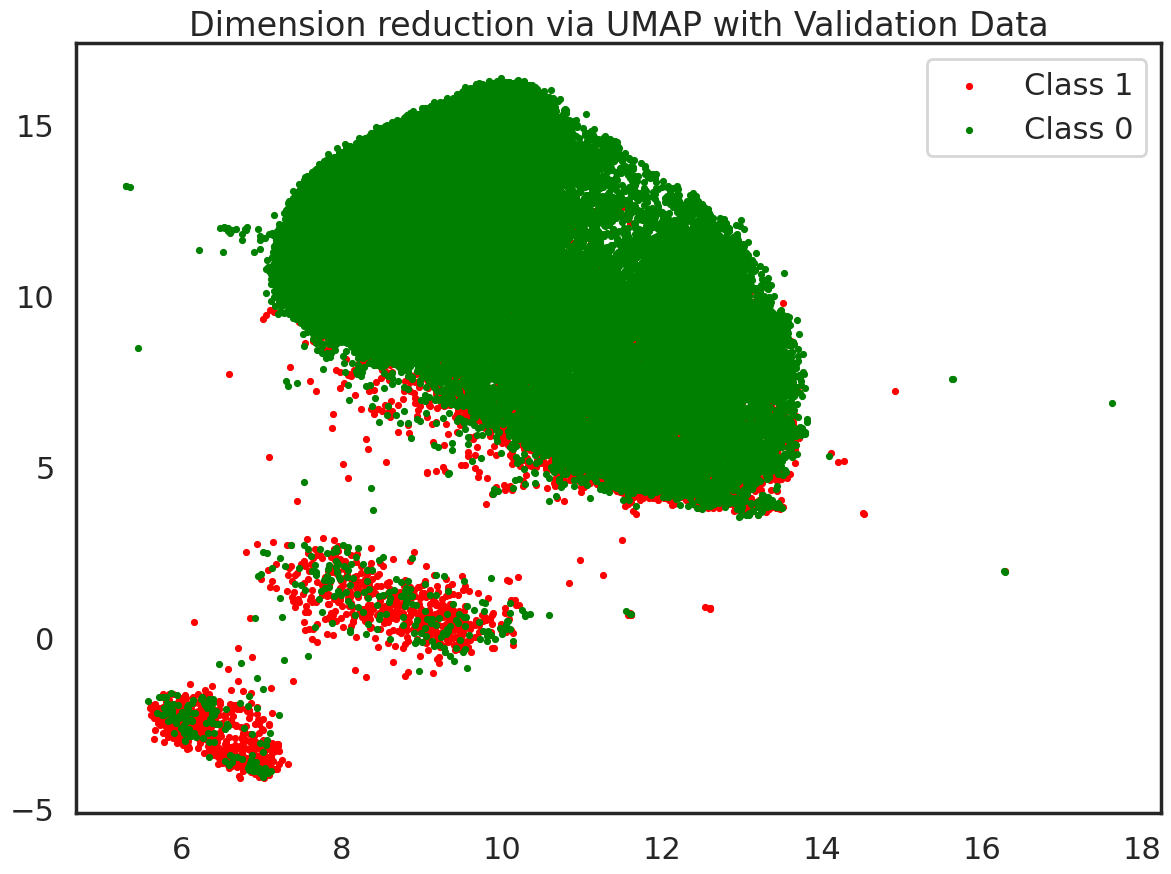

In [ ]:
ml_agent = MLModel('KNN')
#ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
#ml_agent.test(X_test, y_test)
X_projection = ml_agent.reduce_dimension(X_train, y_train, X_test, y_test)

In [ ]:
ml_agent = MLModel('KNN')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
Testing KNN ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9102, Precision: 0.6617, Recall: 0.2665, F1: 0.3800


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



eer rate 0.06681068219529758 and threshold value 0.3333333333333333


(array([0.        , 0.002442  , 0.01568517, 0.06681068, 1.        ]),
 array([1.        , 0.93283481, 0.73351462, 0.38830727, 0.        ]),
 0.3333333333333333)

In [ ]:
ml_agent = MLModel('RandomForest')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

RandomForest is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 0.9996, F1: 0.9998 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Training Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 0.9996, F1: 0.9998
Best parameters: {'n_estimators': 75}
Testing RandomForest ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9233, Precision: 0.8062, Recall: 0.3381, F1: 0.4764


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



eer rate 0.13045928430543816 and threshold value 0.16


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.56538618e-05,
        3.13077236e-05, 3.13077236e-05, 4.69615854e-05, 6.26154472e-05,
        7.82693090e-05, 9.39231708e-05, 1.56538618e-04, 2.03500204e-04,
        2.81769513e-04, 3.91346545e-04, 5.63539025e-04, 6.73116058e-04,
        8.29654676e-04, 1.08011646e-03, 1.28361667e-03, 1.64365549e-03,
        2.09761748e-03, 2.44200244e-03, 2.89596443e-03, 3.36558029e-03,
        4.08565793e-03, 4.71181240e-03, 5.43189005e-03, 6.41808334e-03,
        7.23208416e-03, 8.23393131e-03, 9.36100936e-03, 1.08481262e-02,
        1.25074356e-02, 1.41510911e-02, 1.59669390e-02, 1.81271720e-02,
        2.02874049e-02, 2.24632917e-02, 2.48270248e-02, 2.76134122e-02,
        3.04467612e-02, 3.37966876e-02, 3.73031527e-02, 4.11540027e-02,
        4.54118531e-02, 4.97166651e-02, 5.42875927e-02, 5.93437901e-02,
        6.46817570e-02, 7.05049936e-02, 7.64534611e-02, 8.37168529e-02,
        9.10272064e-02, 9.94333302e-02, 1.08919570e-01, 1.191885

In [ ]:
ml_agent = MLModel('XGBoost')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

XGBoost is training ...
Validation Set Metrics - Accuracy: 0.9489, Precision: 0.9271, Recall: 0.5443, F1: 0.6860 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9574, Precision: 0.9371, Recall: 0.6232, F1: 0.7486
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
Testing XGBoost ...
Test Set Metrics - Accuracy: 0.9302, Precision: 0.7736, Recall: 0.4582, F1: 0.5755
eer rate 0.10422341191571961 and threshold value 0.10124250501394272


(array([0.        , 0.        , 0.        , ..., 0.98408002, 0.98411133,
        1.        ]),
 array([1.        , 0.99986404, 0.99374575, ..., 0.        , 0.        ,
        0.        ]),
 0.101242505)

In [ ]:
ml_agent = MLModel('NaiveBayes')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
fpr, fnr, eer_threshold_test = ml_agent.test(X_test, y_test)

NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}
Testing NaiveBayes ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Test Set Metrics - Accuracy: 0.8704, Precision: 0.4355, Recall: 0.8619, F1: 0.5786


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



eer rate 0.13261951723490184 and threshold value 0.005290010794560163


In [ ]:
ml_agent = MLModel('DecisionTree')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9314, Precision: 0.7586, Recall: 0.4859, F1: 0.5923 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9375, Precision: 0.7730, Recall: 0.5461, F1: 0.6400
Best parameters: {'criterion': 'entropy', 'max_depth': 10}
Testing DecisionTree ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9092, Precision: 0.5998, Recall: 0.3617, F1: 0.4512


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



eer rate 0.143545912776682 and threshold value 0.03215434083601286


(array([0.        , 0.01103597, 0.0113334 , 0.01159951, 0.01181867,
        0.01189693, 0.0119752 , 0.01205347, 0.0123822 , 0.0125857 ,
        0.01278921, 0.01285182, 0.01311794, 0.01338405, 0.01396324,
        0.01407282, 0.01424501, 0.01505902, 0.01518425, 0.01628002,
        0.01687486, 0.01776713, 0.01789236, 0.01809586, 0.01847156,
        0.01972387, 0.0202561 , 0.02133621, 0.02153971, 0.02179018,
        0.02260418, 0.02318337, 0.02341818, 0.02359037, 0.02369995,
        0.02421652, 0.02431045, 0.02528099, 0.02562537, 0.02586018,
        0.02643937, 0.02767603, 0.0277856 , 0.02834914, 0.02864657,
        0.02875614, 0.0295858 , 0.02964841, 0.03011803, 0.03151122,
        0.0324348 , 0.03288876, 0.03509596, 0.035456  , 0.03559688,
        0.03578473, 0.03598823, 0.03627   , 0.03778842, 0.03796061,
        0.03889985, 0.03896246, 0.04046523, 0.04060612, 0.04286027,
        0.04533358, 0.04542751, 0.0464137 , 0.04660155, 0.05035847,
        0.05134467, 0.0516734 , 0.05284744, 0.05

In [ ]:
ml_agent = MLModel('LogisticRegression')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

LogisticRegression is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Validation Set Metrics - Accuracy: 0.9288, Precision: 0.7278, Recall: 0.4878, F1: 0.5841 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9338, Precision: 0.7461, Recall: 0.5298, F1: 0.6197
Best parameters: {'C': 5}
Testing LogisticRegression ...
Test Set Metrics - Accuracy: 0.9341, Precision: 0.7482, Recall: 0.5447, F1: 0.6304
eer rate 0.11563507717353871 and threshold value 0.10268536269036004


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



(array([0.        , 0.        , 0.        , ..., 0.86644125, 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99864038e-01, 9.92658056e-01, ...,
        1.35961931e-04, 1.35961931e-04, 0.00000000e+00]),
 0.10268536269036004)

In [ ]:
ml_agent = MLModel('SVM')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

SVM is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9391, Precision: 0.8294, Recall: 0.5114, F1: 0.6327 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 0.9459, Precision: 0.8386, Recall: 0.5802, F1: 0.6859
Best parameters: {'C': 5, 'kernel': 'linear'}
Testing SVM ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Test Set Metrics - Accuracy: 0.9373, Precision: 0.7646, Recall: 0.5675, F1: 0.6515


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


eer rate 0.11151811151811152 and threshold value 0.11504187386860391


(array([0.        , 0.        , 0.        , ..., 0.90108325, 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99864038e-01, 9.95921142e-01, ...,
        1.35961931e-04, 1.35961931e-04, 0.00000000e+00]),
 0.11504187386860391)

In [ ]:
ml_agent = MLModel('MLP')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

MLP is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Stacking Test Set Metrics - Accuracy: 0.9008, Precision: 0.5165, Recall: 0.6077, F1: 0.5584
eer rate 0.06563664255971949 and threshold value 0.3333333333333333


(array([0.        , 0.00414827, 0.00475877, 0.01709402, 0.03137034,
        0.06551141, 0.06562099, 0.06563664, 1.        ]),
 array([1.        , 0.92603671, 0.92182189, 0.72902787, 0.7053705 ,
        0.39225017, 0.39211421, 0.39211421, 0.        ]),
 0.3333333333333333)

In [ ]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes', 'DecisionTree']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}
DecisionTree is training
DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9313, Precision: 0.7575, Recall: 0.4855, F1: 0.5917 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9375, Precision: 0.7725, Recall: 0.5461, F1: 0.6399
Best parameters: {'criterion': 'entropy', 'max_depth': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Stacking Test Set Metrics - Accuracy: 0.9184, Precision: 0.6386, Recall: 0.4821, F1: 0.5494
eer rate 0.04624150777996932 and threshold value 0.07142857142857142


(array([0.        , 0.01141167, 0.01172474, 0.01188128, 0.01227263,
        0.01249178, 0.01285182, 0.01349363, 0.01366582, 0.01368148,
        0.0141824 , 0.01496509, 0.01527817, 0.01532513, 0.01563821,
        0.01591998, 0.01609217, 0.01643655, 0.01670267, 0.01700009,
        0.01809586, 0.01867506, 0.01887856, 0.0192699 , 0.01956733,
        0.02013087, 0.02031871, 0.02085094, 0.02108575, 0.02150841,
        0.02191541, 0.02200933, 0.0243261 , 0.02487399, 0.02543753,
        0.02611064, 0.02626718, 0.02703422, 0.02720641, 0.02823957,
        0.02874049, 0.02967972, 0.03113553, 0.0314173 , 0.03378103,
        0.03479853, 0.03517423, 0.03534642, 0.03600388, 0.03656742,
        0.03879027, 0.03980777, 0.04076266, 0.04120096, 0.04163927,
        0.04284462, 0.04323597, 0.04439435, 0.04484831, 0.04520835,
        0.04550578, 0.04586582, 0.04624151, 1.        ]),
 array([1.        , 0.82855201, 0.81889871, 0.81495581, 0.80231135,
        0.79972808, 0.79170632, 0.77647859, 0.76288239, 0.

In [ ]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes', 'XGBoost', 'DecisionTree']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}
XGBoost is training
XGBoost is training ...
Validation Set Metrics - Accuracy: 0.9489, Precision: 0.9271, Recall: 0.5443, F1: 0.6860 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9574, Precision: 0.9371, Recall: 0.6232, F1: 0.7486
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
DecisionTree is training
DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9814, Precision: 0.9749, Recall: 0.8399, F1: 0.9024 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9832, Precision: 0.9716, Recall: 0.8603, F1: 0.9126
Best parameters: {'criterion': 'entropy', 'max_depth': 15}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Stacking Test Set Metrics - Accuracy: 0.9187, Precision: 0.6876, Recall: 0.3902, F1: 0.4979
eer rate 0.02041263579725118 and threshold value 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



(array([0.        , 0.02041264, 1.        ]),
 array([1.        , 0.60978926, 0.        ]),
 1.0)

In [3]:
"""
import torch
from speechbrain.utils.metric_stats import EER

positive_scores = torch.tensor([0.6, 0.7, 0.8, 0.5])
negative_scores = torch.tensor([0.4, 0.3, 0.2, 0.1])
val_eer, threshold = EER(positive_scores, negative_scores)
val_eer
"""

0.0

In [4]:
#threshold

0.4000000059604645